In [1]:
import pandas as pd
import bambi as bmb
import pingouin as pg
import joblib
from os import listdir
from os.path import join
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az


sns.set_style('ticks')
sns.set_context('poster')

%matplotlib inline

INDIR = '/mnt/obob/staff/fschmidt/cardiac_1_f/data/c_1_f_resting_sbg'
my_freqs = '_1_150'
all_files = [file for file in listdir(INDIR) if my_freqs in file]
len(all_files)

/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


685

In [2]:
all_df, all_psd = [], []
for file in all_files:
    cur_data = joblib.load(join(INDIR, file))
    
    if 'ecg_scores' in cur_data.keys() and (cur_data['ecg_scores'] > 0.5).sum() > 0:
    
        def make_data_meg(cur_data, key):
            cur_psd = pd.DataFrame(cur_data['psd'].mean(axis=0))
            cur_psd['channel'] = np.arange(102)
            psd_melt = cur_psd.melt(id_vars='channel')
            psd_melt['Frequency (Hz)'] = psd_melt['variable'].replace(dict(zip(np.arange(300), cur_data['freqs'])))
            psd_melt.drop(labels='variable', axis=1, inplace=True)
            psd_melt.columns = ['channel', key, 'Frequency (Hz)']
            return psd_melt

        mags_df = make_data_meg(cur_data['data_brain']['mag'], 'Magnetometers (ECG removed)')
        mags_heart_df = make_data_meg(cur_data['data_heart']['mag'], 'ECG Component Magnetometers')
        mags_no_ica_df = make_data_meg(cur_data['data_no_ica']['mag'], 'Magnetometers (ECG present)')

        df_meg_cmb = mags_df.merge(mags_heart_df, on=['channel', 'Frequency (Hz)'])
        df_meg_cmb = df_meg_cmb.merge(mags_no_ica_df, on=['channel', 'Frequency (Hz)'])                    
        df_ecg = pd.DataFrame({'ECG Electrode' : cur_data['data_heart']['ecg']['psd'][0,:][0],
                               'Frequency (Hz)': cur_data['data_heart']['ecg']['freqs'],})
        
        df_psd = df_meg_cmb.merge(df_ecg, on='Frequency (Hz)')
        df_psd['subject_id'] = cur_data['subject_id']
        df_psd['age'] = cur_data['age']
        all_psd.append(df_psd)

    
        all_df.append(pd.DataFrame({'heart_slope_mag': cur_data['data_heart']['mag']['exponents'],
                                'brain_slope': cur_data['data_brain']['mag']['exponents'],
                                'brain_no_ica': cur_data['data_no_ica']['mag']['exponents'],
                                'heart_slope': cur_data['data_heart']['ecg']['exponents'][0],
                                'heart_slope_avg': cur_data['data_heart']['mag']['aps_mag']['Exponent'].mean(),
                                'brain_slope_avg': cur_data['data_brain']['mag']['aps_mag']['Exponent'].mean(),
                                'no_ica_slope_avg': cur_data['data_no_ica']['mag']['aps_mag']['Exponent'].mean(),
                                'channel': np.arange(102),
                                'subject_id': cur_data['subject_id'],
                                'age': cur_data['age'],
                                'meas_date': cur_data['meas_date'],
                                'days': cur_data['days']}))
df_cmb = pd.concat(all_df)
df_cmb_psd = pd.concat(all_psd)

In [3]:
avg_psd = df_cmb_psd.groupby(['Frequency (Hz)', 'channel']).mean().reset_index()
df_cmb_psd

,channel,Magnetometers (ECG removed),Frequency (Hz),ECG Component Magnetometers,Magnetometers (ECG present),ECG Electrode,subject_id,age
0,0,5.319152e-27,1.0,1.288910e-27,4.961803e-26,1.039135e-08,19930920gbzp,23
1,1,2.957099e-27,1.0,2.191448e-28,5.585917e-26,1.039135e-08,19930920gbzp,23
2,2,3.478675e-27,1.0,5.362380e-29,7.485809e-27,1.039135e-08,19930920gbzp,23
3,3,6.107329e-27,1.0,1.133743e-27,1.817262e-26,1.039135e-08,19930920gbzp,23
4,4,4.072516e-27,1.0,9.236247e-29,6.363908e-27,1.039135e-08,19930920gbzp,23
...,...,...,...,...,...,...,...,...
30493,97,8.836398e-29,150.0,1.459165e-29,1.152489e-28,2.437714e-13,19950719mrmd,26
30494,98,1.037307e-29,150.0,3.023868e-30,1.073720e-29,2.437714e-13,19950719mrmd,26
30495,99,2.393655e-29,150.0,2.625820e-30,1.758530e-29,2.437714e-13,19950719mrmd,26
30496,100,1.347870e-29,150.0,6.138998e-30,2.403915e-29,2.437714e-13,19950719mrmd,26


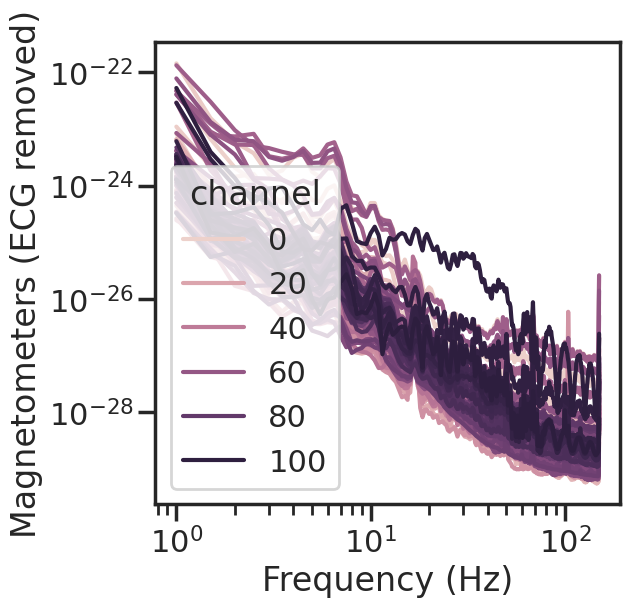

In [4]:
#%%
fig, ax = plt.subplots()
sns.lineplot(x='Frequency (Hz)', y='Magnetometers (ECG removed)',
             hue="channel",
             data=avg_psd, ax=ax)
fig.set_size_inches(6,6)
plt.xscale('log')
plt.yscale('log')
#fig.savefig(f'../results/mags_ga_ecg_removed{my_freqs}.svg')
#%%


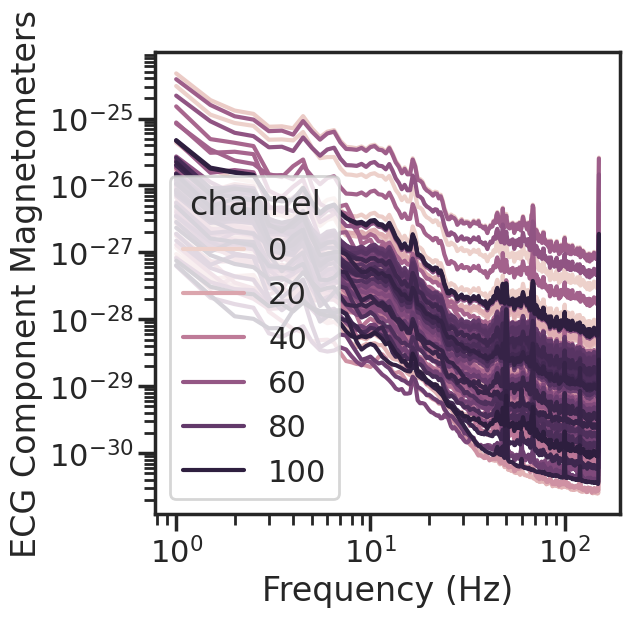

In [5]:
fig, ax = plt.subplots()
sns.lineplot(x='Frequency (Hz)', y='ECG Component Magnetometers',
             hue="channel",
             data=avg_psd, ax=ax)
fig.set_size_inches(6,6)
plt.xscale('log')
plt.yscale('log')
#fig.savefig(f'../results/mags_ga_ecg_component{my_freqs}.svg')
#%%


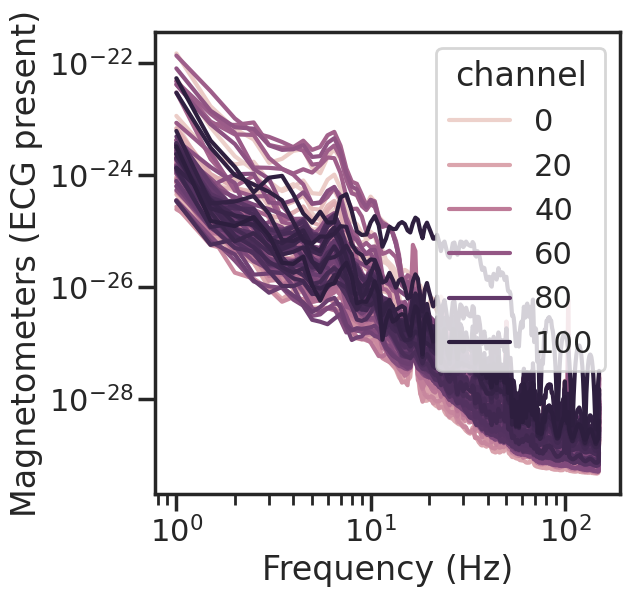

In [6]:
fig, ax = plt.subplots()
sns.lineplot(x='Frequency (Hz)', y='Magnetometers (ECG present)',
             hue="channel",
             data=avg_psd, ax=ax)
fig.set_size_inches(6,6)
plt.xscale('log')
plt.yscale('log')
#fig.savefig(f'../results/mags_ga_ecg_present{my_freqs}.svg')

In [7]:
# %%
df_cmb.to_csv('../data/sbg_1_f_dataframe_1_150.csv')

In [8]:
cur_df_cmb = df_cmb.query('channel == 0')


def plot_slope_age_corr(key, x, y, color):
    corr = pg.corr(cur_df_cmb['age'], cur_df_cmb[key], method='shepherd')

    g = sns.lmplot(data=cur_df_cmb, x='age', y=key, 
                    line_kws={'color': color}, 
                    scatter_kws={"s": 40, 'color': '#888888', 'alpha': 0.25})

    r = round(float(corr['r']), 2)
    p = round(float(corr['p-val']), 3)

    if p == 0.0:
        p = 'p < 0.001'
    else:
        p = f'p = {p}'

    plt.annotate(text=f'r = {r}', xy=(x, y))
    plt.annotate(text=p, xy=(x, y - 0.2))

    g.set_xlabels('age (years)')
    g.set_ylabels('1/f slope')
    #g.ax.figure.savefig(f'../results/corr_{key}_{my_freqs}.svg', )

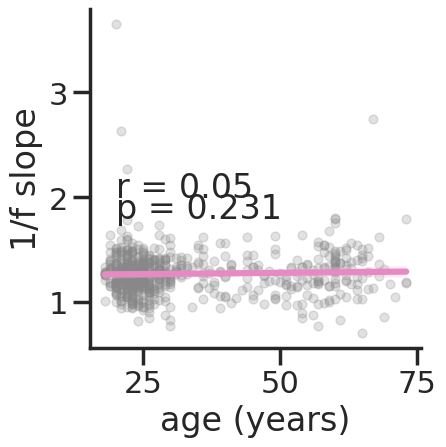

In [9]:
#%%
plot_slope_age_corr('no_ica_slope_avg', 20, 2., '#e78ac3')

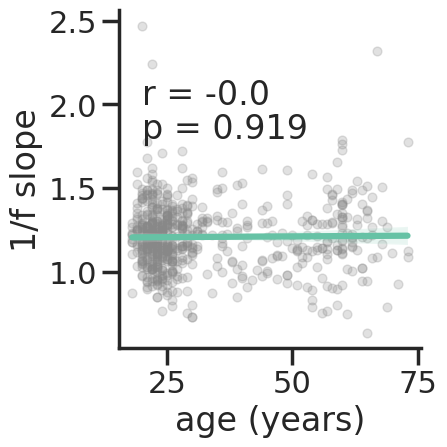

In [10]:
#%%
plot_slope_age_corr('brain_slope_avg', 20, 2., '#66c2a5')

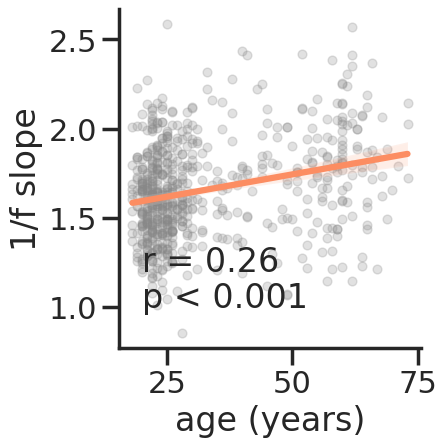

In [11]:
#%%
plot_slope_age_corr('heart_slope_avg', 20, 1.2, '#fc8d62')

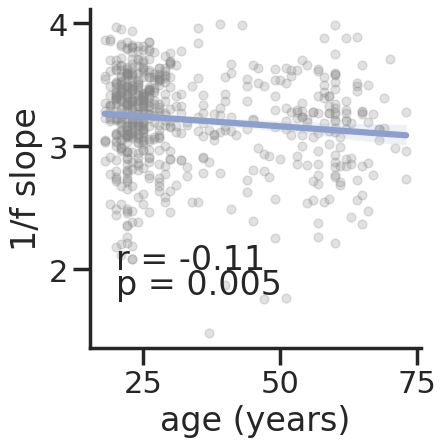

In [12]:
plot_slope_age_corr('heart_slope', 20, 2., '#8da0cb')

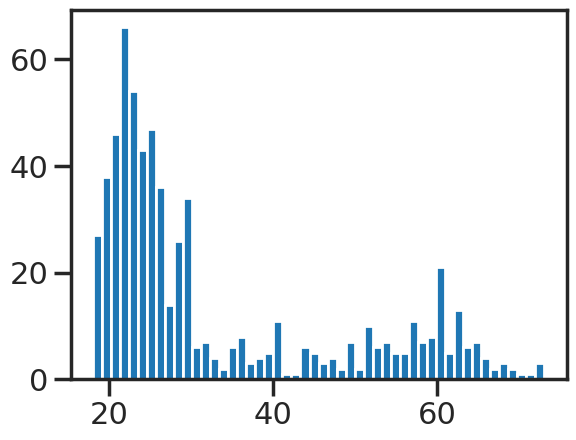

In [34]:
plt.hist(cur_df_cmb['age'], bins=50);

In [40]:
mdf = bmb.Model(data=cur_df_cmb, 
                formula='age ~ brain_slope_avg + heart_slope_avg', 
                dropna=True,
                family='gamma',
                link='log',
                ).fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, brain_slope_avg, heart_slope_avg, days_alpha]


ValueError: Not enough samples to build a trace.

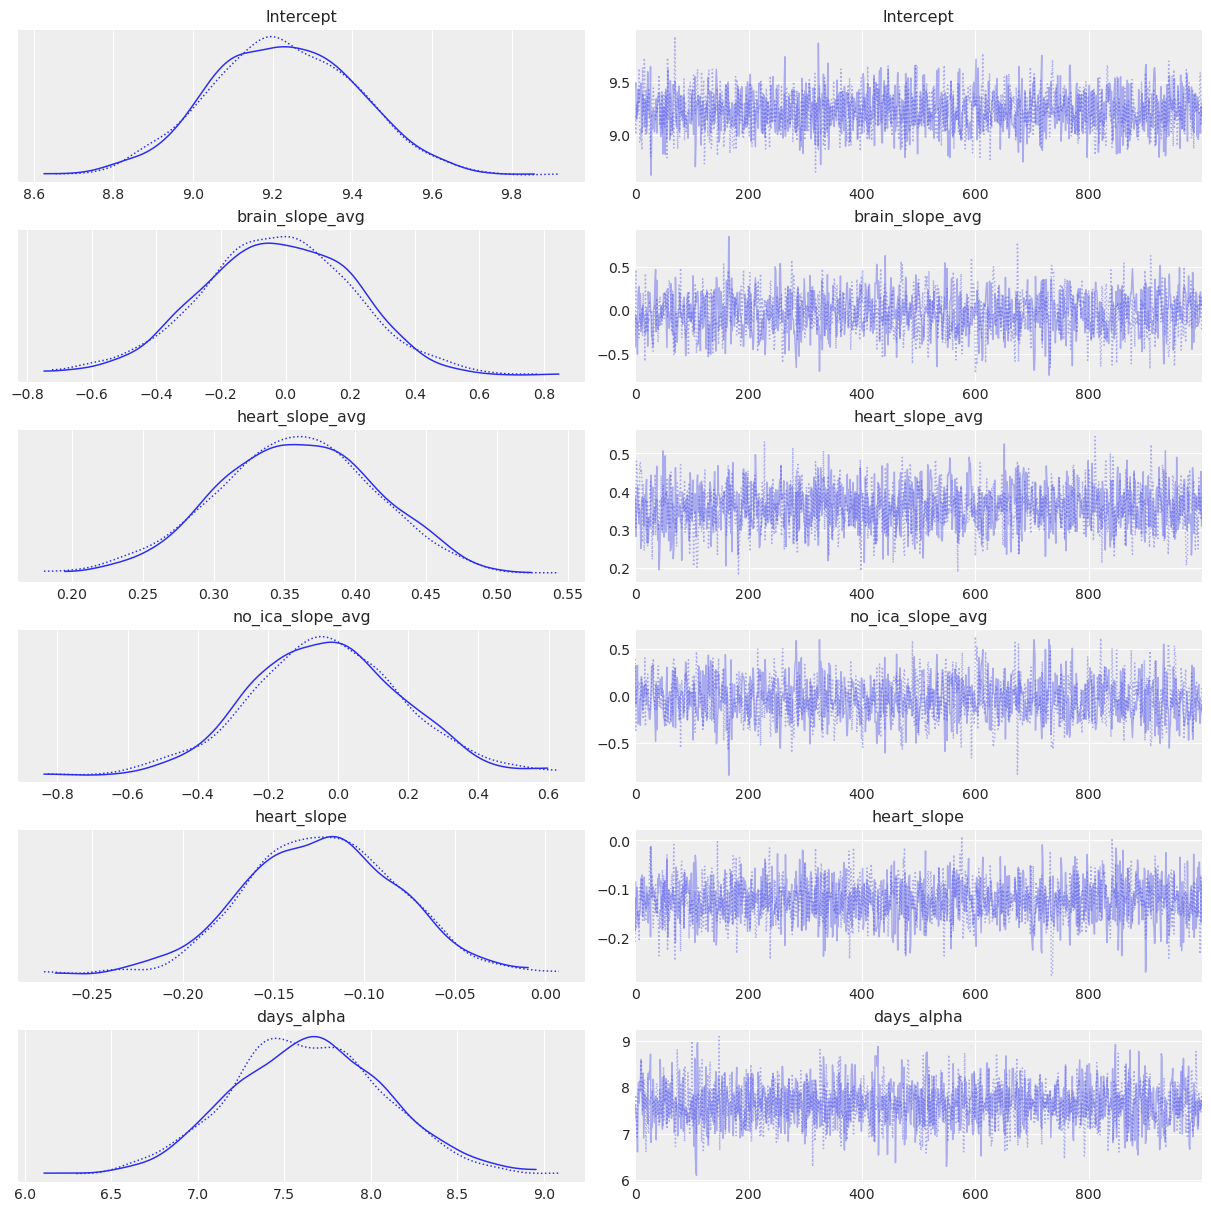

In [1014]:
with az.style.use("arviz-darkgrid"):
    az.plot_trace(mdf);

In [ ]:
az.summary(mdf)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,9.228,0.182,8.866,9.546,0.004,0.003,1904.0,1705.0,1.0
brain_slope_avg,-0.031,0.233,-0.471,0.397,0.006,0.005,1292.0,1325.0,1.0
heart_slope_avg,0.358,0.056,0.254,0.465,0.001,0.001,1670.0,1331.0,1.0
no_ica_slope_avg,-0.031,0.215,-0.465,0.351,0.006,0.005,1294.0,1156.0,1.0
heart_slope,-0.123,0.042,-0.200,-0.046,0.001,0.001,1829.0,1376.0,1.0
days_alpha,7.640,0.443,6.811,8.453,0.010,0.007,1910.0,1240.0,1.0
